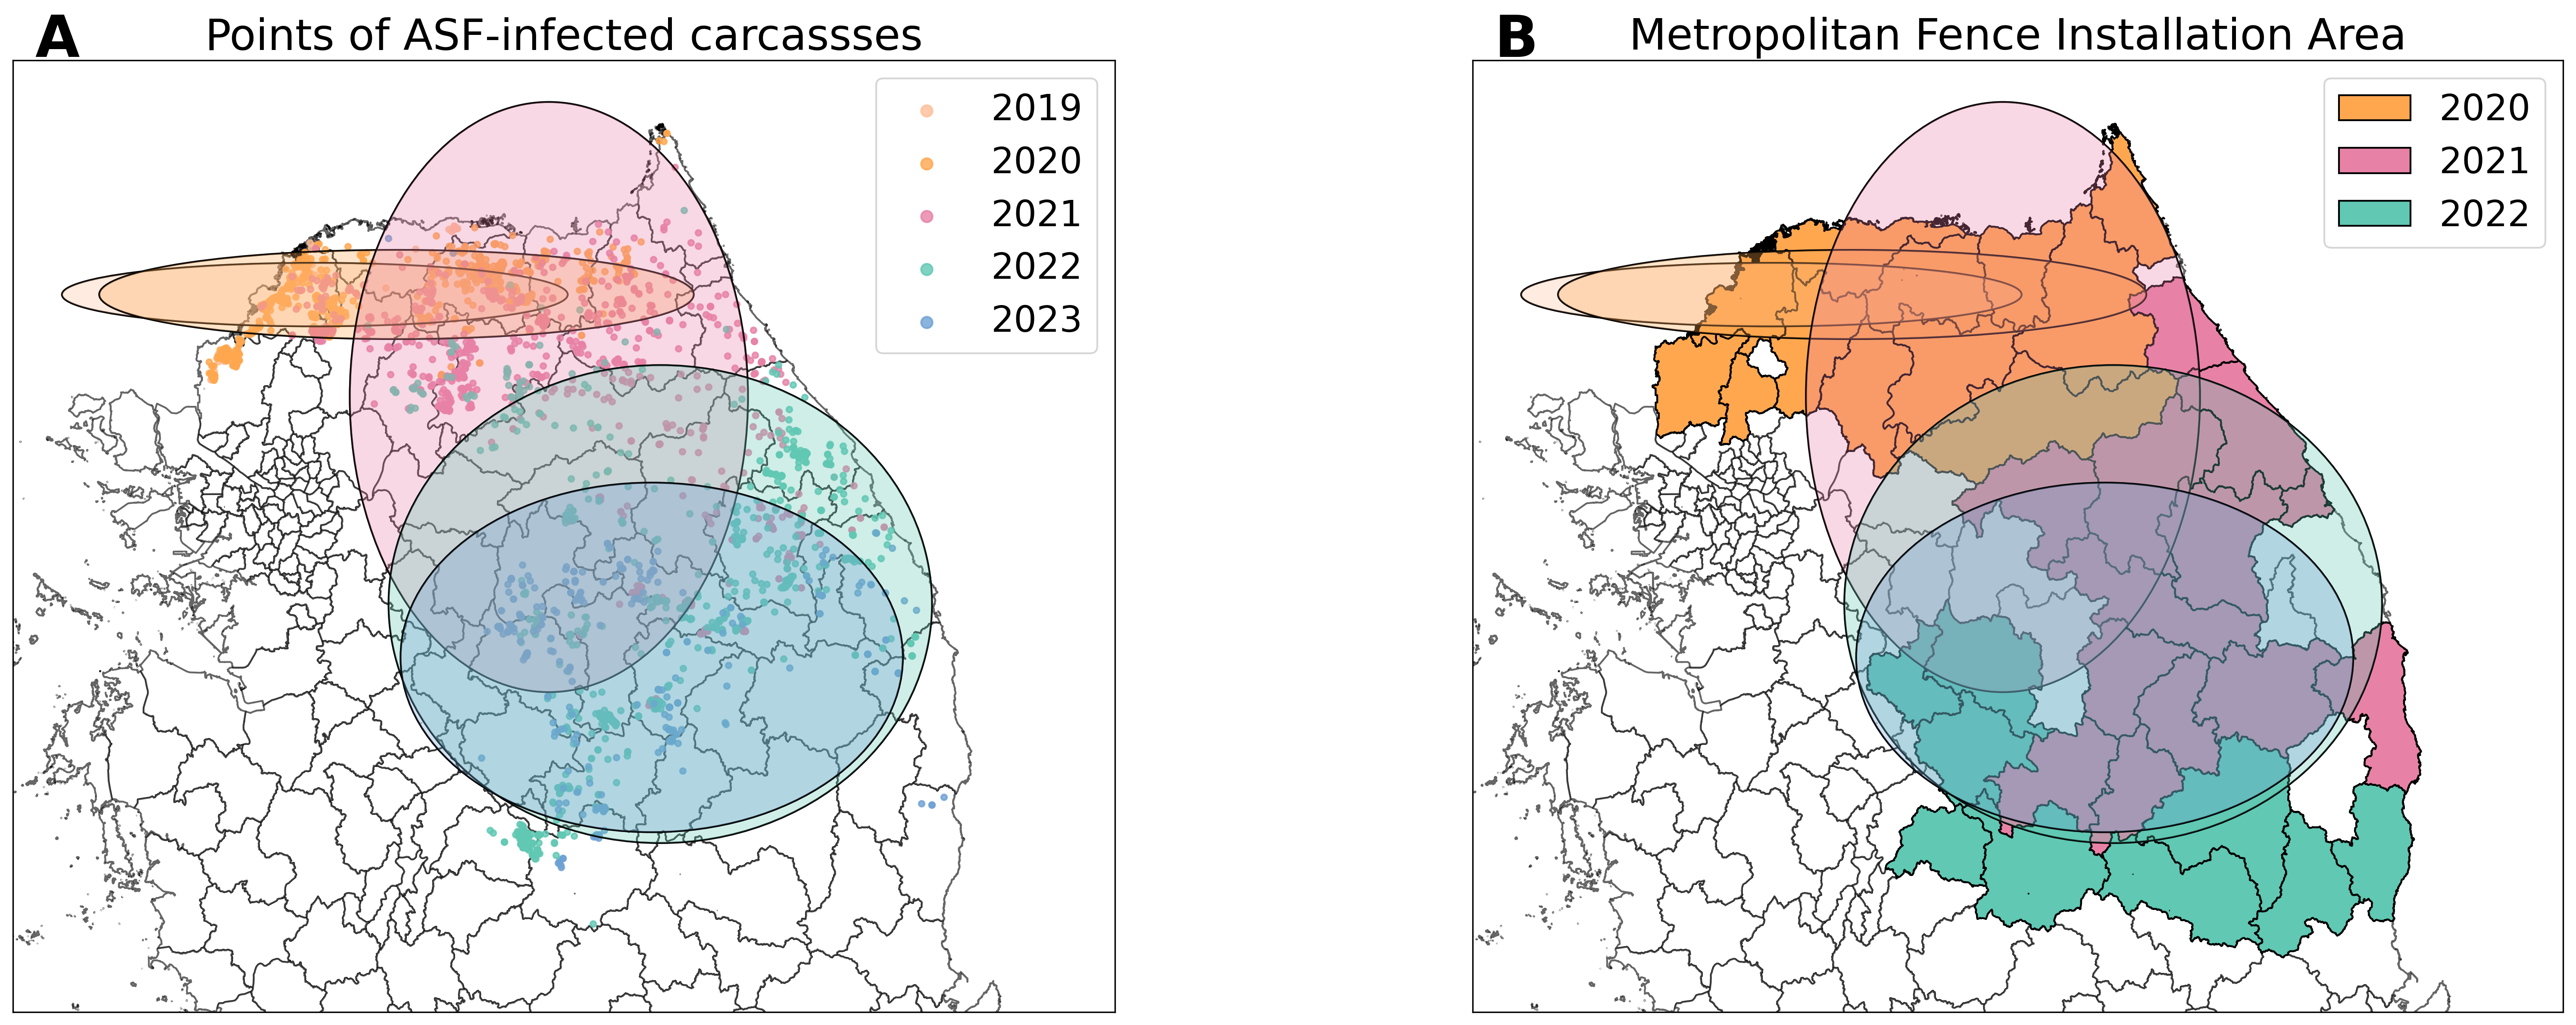

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import numpy as np
import matplotlib.transforms as transforms
import os

os.chdir("../Data")

location_path = 'ASF_WildBoar_Update.csv'
korea_path = 'sig_5179.shp'

location = pd.read_csv(location_path)
korea = gpd.read_file(korea_path)

korea = korea.to_crs(epsg=4326)
location.loc[location['경도'].str[-2] == '.','경도'] = 128.3489
location['위도'] = location['위도'].str.replace(',', '')
location['경도'] = location['경도'].astype(float)
location['위도'] = location['위도'].astype(float)
location['확진'] = pd.to_datetime(location['확진'], format='%Y-%m-%d')
location = location.rename(columns={'위도': 'y', '경도': 'x'}, inplace=False)

location_2019 = location.query('확진 < "2020-01-01"')
location_2020 = location.query('확진 >= "2020-01-01" & 확진 < "2021-01-01"')
location_2021 = location.query('확진 >= "2021-01-01" & 확진 < "2022-01-01"')
location_2022 = location.query('확진 >= "2022-01-01" & 확진 < "2023-01-01"')
location_2023 = location.query('확진 >= "2023-01-01" & 확진 < "2024-01-01"')

color_year2 = ['#FFBE98', '#FFA74F', '#E881A6', '#60C8B3', '#6EA1D4']

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', edge_alpha=1.0, **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, alpha=0.3, linewidth=1, **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    
    if edgecolor != 'none':
        edge_patch = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                             facecolor='none', edgecolor=edgecolor, alpha=edge_alpha, linewidth=1, **kwargs)
        edge_patch.set_transform(transf + ax.transData)
        ax.add_patch(edge_patch)
    
    return ax.add_patch(ellipse)
fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=300)

ax = axs[0]
korea.plot(ax=ax, color='white', edgecolor='black', alpha=0.6)
ax.set_xlim([126, 130])
ax.set_ylim([36, 38.8])
ax.scatter(location_2019['x'], location_2019['y'], s=10, color=color_year2[0], alpha=0.8, label='2019')
ax.scatter(location_2020['x'], location_2020['y'], s=10, color=color_year2[1], alpha=0.8, label='2020')
ax.scatter(location_2021['x'], location_2021['y'], s=10, color=color_year2[2], alpha=0.8, label='2021')
ax.scatter(location_2022['x'], location_2022['y'], s=10, color=color_year2[3], alpha=0.8, label='2022')
ax.scatter(location_2023['x'], location_2023['y'], s=10, color=color_year2[4], alpha=0.8, label='2023')

confidence_ellipse(location_2019['x'], location_2019['y'], ax, n_std=2.0, facecolor=color_year2[0])
confidence_ellipse(location_2020['x'], location_2020['y'], ax, n_std=2.0, facecolor=color_year2[1])
confidence_ellipse(location_2021['x'], location_2021['y'], ax, n_std=2.0, facecolor=color_year2[2])
confidence_ellipse(location_2022['x'], location_2022['y'], ax, n_std=2.0, facecolor=color_year2[3])
confidence_ellipse(location_2023['x'], location_2023['y'], ax, n_std=2.0, facecolor=color_year2[4])

ax.legend(fontsize=20, markerscale=2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Points of ASF-infected carcassses', fontsize=24)
ax.text(0.02, 1.05, 'A', fontweight='bold',  transform=ax.transAxes, fontsize=32, verticalalignment='top')

stage1 = ["파주시", "양주시", "연천군", "포천시", "가평군", "철원군", "춘천시", "화천군", "양구군", "인제군", "고성군", "양구군", "인제군", '홍천군']
stage2 = ["파주시", "양주시", "연천군", "포천시", "가평군", "춘천시", "화천군", "인제군", "양양군", "강릉시", "동해시", "평창군", "영월군", "정선군", "횡성군", "문경시", "단양군", "예천군", "영주시", "봉화군", "울진군"]
stage3 = ["음성군", "충주시", "괴산군", "보은군", "상주시", "의성군", "안동시", "청송군", "영덕군"]

korea['stage1'] = 0
korea['stage2'] = 0
korea['stage3'] = 0

special_index = 133

for idx, row in korea.iterrows():
    if row['SIG_KOR_NM'] in stage1:
        if row['SIG_KOR_NM'] == '고성군' and idx != special_index:
            continue
        korea.at[idx, 'stage1'] = 1
    if row['SIG_KOR_NM'] in stage2:
        if row['SIG_KOR_NM'] == '고성군' and idx != special_index:
            continue
        korea.at[idx, 'stage2'] = 1
    if row['SIG_KOR_NM'] in stage3:
        if row['SIG_KOR_NM'] == '고성군' and idx != special_index:
            continue
        korea.at[idx, 'stage3'] = 1

ax = axs[1]
korea.plot(ax=ax, color='white', edgecolor='black', alpha=0.6)
korea[korea['stage2'] == 1].plot(ax=ax, color=color_year2[2], edgecolor='black')
korea[korea['stage1'] == 1].plot(ax=ax, color=color_year2[1], edgecolor='black')
korea[korea['stage3'] == 1].plot(ax=ax, color=color_year2[3], edgecolor='black')

confidence_ellipse(location_2019['x'], location_2019['y'], ax, n_std=2.0, facecolor=color_year2[0])
confidence_ellipse(location_2020['x'], location_2020['y'], ax, n_std=2.0, facecolor=color_year2[1])
confidence_ellipse(location_2021['x'], location_2021['y'], ax, n_std=2.0, facecolor=color_year2[2])
confidence_ellipse(location_2022['x'], location_2022['y'], ax, n_std=2.0, facecolor=color_year2[3])
confidence_ellipse(location_2023['x'], location_2023['y'], ax, n_std=2.0, facecolor=color_year2[4])

legend_elements = [
    Patch(facecolor=color_year2[1], edgecolor='black', label='2020'),
    Patch(facecolor=color_year2[2], edgecolor='black', label='2021'),
    Patch(facecolor=color_year2[3], edgecolor='black', label='2022')
]

ax.legend(handles=legend_elements, fontsize=20, markerscale=2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Metropolitan Fence Installation Area', fontsize=24)
ax.set_xlim([126, 130])
ax.set_ylim([36, 38.8])
ax.text(0.02, 1.05, 'B', transform=ax.transAxes, fontweight='bold',  fontsize=32, verticalalignment='top')

plt.tight_layout()
plt.show()